# Advanced programming lab: Mandelbrot zoom
 
*version 1, since this lab is new for 2020, details/bugs in this lab might be fixed within the first week of publication, you will be notified by email if this happens*
 
The mandelbrot zoom was a classic rite of initiation in some hacker circles in the 90s. For this lab, you are given code for generating such a mandelbrot zoom, however, the code is written in pure python and is really slow. Your task is as follows:
 
1. Copy the given mandelbrot code to the the prepared cython code cell below.
2. Step by step, optimise the code using the tricks discussed in class.
3. The rendering of the frames is an *embarrassingly parallel* task. See to that your frames are rendered on several CPU cores.
4. Generate a 500 frame video at a 1000x1000 pixel resolution.
 
Your implementation should be **at least** 50 times faster than the given code on an 8 core system.
 
## Submission
 
When you are done, hand in the notebook through studentportalen. Requirements are:
1. Clean the notebook from unused code and unnecessary text.
2. Save the notebook with plotted images, but not the video (it’s too large).
3. Comment on what was hard and easy in the assignment (in a handful of sentences).

First, we need some libraries. The line profiler needs some underlying software to work.

In [0]:
import numpy as np
#!pip install opencv-python
import cv2 # open computer vision library, for video and image processing
import matplotlib.pyplot as plt

# Code for enabling line specific profiling
#!pip install line-profiler
#%load_ext line_profiler

The numbers in the Mandelbrot set are all complex numbers $c$, such that the series $z_0=(0, 0)$ and $z_{t+1} = z_t^2 + c$ is bounded (i.e. it does not go to infinity). $c$ is a complex constant depending on the position in the image being processed. We set the pixel colour in relation to the number of iterations in the series before it diverges, defined as $|z_t| > 2$.

In [0]:
def mandelbrot(centre, view_side, n_max_iter = 500, view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  step = view_side/view_side_pixels
  # Store the pixels as a list of lists
  image = list()
  for i in range(view_side_pixels):
    image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      # Initial z
      z = complex(0, 0)
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and abs(z) < 2: 
        # The update
        z = z*z + c
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n == n_max_iter:
        image[i].append(0)
      else:
        image[i].append(n)
  # Transform the list of lists into a numpy matrix
  return np.asarray(image)

This code is for viewing the generated image. A colourmap is applied to the raw counts of iterations before diverging. There are more beautiful colourmaps, but none in opencv. You can try out other colourmaps as described [here](https://docs.opencv.org/3.4.9/d3/d50/group__imgproc__colormap.html).

Note that opencv use BGR instead of RGB colour ordering.

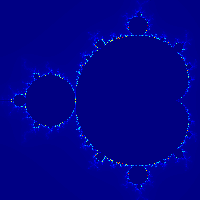

In [3]:
# Make the image
image = mandelbrot(complex(-.5, 0), 2, view_side_pixels = 200)
# image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
# img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

## Making a video zooming in on the fractal image

In [4]:
from tqdm import tqdm

frames = list()
for zoom in tqdm(np.exp(np.linspace(np.log(1), np.log(.00001), 10))):
  # Create the image for the given parameters
  image = mandelbrot(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), zoom, n_max_iter=255, view_side_pixels = 100)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

  # Store the frame
  frames.append(img)

100%|██████████| 10/10 [00:09<00:00,  1.04s/it]


Just to see what came out, the following cell shows the first, middle and last frames.

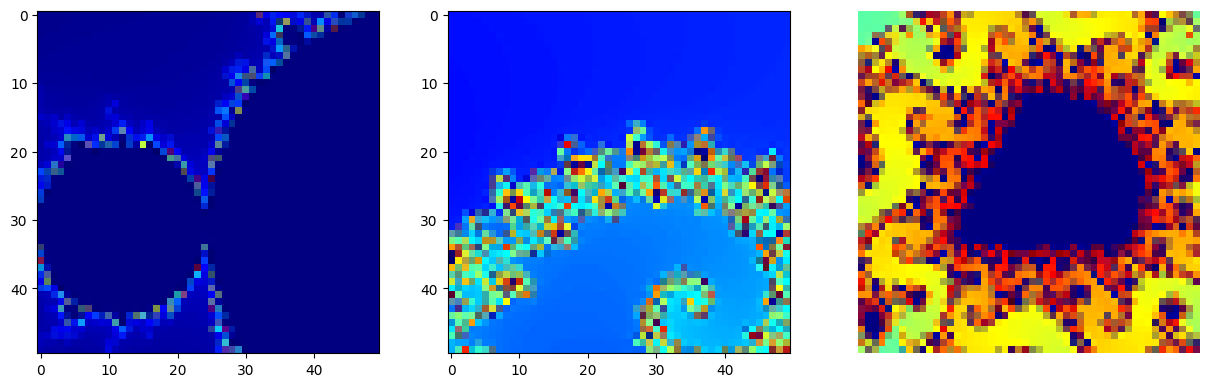

In [5]:
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frames[len(frames)//2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

This writes the video to disk. Note that if you do this through colab, your video will be written to the viritual machine's disk. You can find some code for downloading the file below.

In [6]:
# Choose video format
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Prepare the writer class
video = cv2.VideoWriter('fractal.mp4',fourcc, 20, (img.shape[0], img.shape[1]))

# Input the frames
for frame in frames:
  video.write(frame)

# Write to disk
video.release()

# Show the files in your working directory
!ls -l

total 36
-rw-r--r-- 1 root root 19665 Feb 28 16:39 fractal.mp4
-rw-r--r-- 1 root root 10730 Feb 28 16:38 fractal.png
drwxr-xr-x 1 root root  4096 Feb  5 18:37 sample_data


## Cython implementation

We implemented the Cython version of the Mandelbrot algorithm. Modifying the code was not too dificult, but get Cython working correctly was more difficult.

In [0]:
%load_ext cython

In [8]:
%%cython -a

import numpy as np
cimport cython
#cython: language_level=3

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def _mandelbrot_cy(centre,view_side, int n_max_iter = 500, int view_side_pixels = 500):
    # Define C variables
    cdef int n=0,i,j,nmax = n_max_iter
    cdef double zr, zi, tmp
    cdef double zrsq, zisq
    cdef double step = view_side/view_side_pixels
    cdef double centrer = centre.real - 0.5 * view_side, centrei=centre.imag + 0.5 * view_side
    cdef double cr, ci = centrei
    # Store the pixels as numpy array
    image = np.zeros((view_side_pixels,view_side_pixels))
    # Create memory view
    cdef double[:,:] im_memview=image
    for i in range(view_side_pixels):
        cr = centrer
        for j in range(view_side_pixels):
            # Find c for this pixel
            # The original formula:
            # c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
            # The first and second parts are constant throughout the function
            # The third part changes only with one step at each iteration
            # Therefore addition is used, instead of multiplication
            cr += step
            # Initial z, real and imaginary part
            zr = 0
            zi = 0
            # The square of the imaginary and the real part of z
            zrsq = 0
            zisq = 0
            # Iterate to generate the series
            n = 0
            # Loop until a maximum number of allowed iterations or until the 
            # series diverges.
            # Use the minimum number of multiplication, using addition whenever possible
            while n < n_max_iter and zrsq + zisq <4:
                # The update
                # z = z*z + c
                # zi = 2 * zr * zi + ci (in steps)
                zi *= zr
                zi += zi
                zi += ci
                # zr = zr* zr - zi * zi + cr (in steps)
                zr = zrsq - zisq + cr
                zrsq = zr * zr
                zisq = zi * zi
                # Increase the iteration counter
                n += 1
                # If the series did diverge, store the number of iterations it took (our
                # colouring will be proportional to this). If not, store a zero.
            # We only need to update the matrix if the series diverged
            if n != n_max_iter:
                im_memview[i,j]=n
        ci -= step
    return image




In [9]:
%%writefile _mandelbrot.pyx

import numpy as np
cimport cython
#cython: language_level=3

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def _mandelbrot_cy(centre,view_side, int n_max_iter = 500, int view_side_pixels = 500):
    # Define C variables
    cdef int n=0,i,j,nmax = n_max_iter
    cdef double zr, zi, tmp
    cdef double zrsq, zisq
    cdef double step = view_side/view_side_pixels
    cdef double centrer = centre.real - 0.5 * view_side, centrei=centre.imag + 0.5 * view_side
    cdef double cr, ci = centrei
    # Store the pixels as numpy array
    image = np.zeros((view_side_pixels,view_side_pixels))
    # Create memory view
    cdef double[:,:] im_memview=image
    for i in range(view_side_pixels):
        cr = centrer
        for j in range(view_side_pixels):
            # Find c for this pixel
            # The original formula:
            # c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
            # The first and second parts are constant throughout the function
            # The third part changes only with one step at each iteration
            # Therefore addition is used, instead of multiplication
            cr += step
            # Initial z, real and imaginary part
            zr = 0
            zi = 0
            #The square of the imaginary and the real part of z
            zrsq = 0
            zisq = 0
            # Iterate to generate the series
            n = 0
            # Loop until a maximum number of allowed iterations or until the 
            # series diverges.
            # Use the minimum number of multiplication, using addition whenever possible
            while n < n_max_iter and zrsq + zisq <4:
                # The update
                # z = z*z + c
                # zi = 2 * zr * zi + ci (in steps)
                zi *= zr
                zi += zi
                zi += ci
                # zr = zr* zr - zi * zi + cr (in steps)
                zr = zrsq - zisq + cr
                zrsq = zr * zr
                zisq = zi * zi
                # Increase the iteration counter
                n += 1
                # If the series did diverge, store the number of iterations it took (our
                # colouring will be proportional to this). If not, store a zero.
            # We only need to update the matrix if the series diverged
            if n != n_max_iter:
                im_memview[i,j]=n
        ci -= step
    return image



Writing _mandelbrot.pyx


Pyximport lets you load cython code as a library and compiles it at loading time. There is also a handy caching of compiled modules, so that you don't recompile on every load of the module. However, this can also lead to problems when developing.

In [10]:
import pyximport
pyximport.install()

from _mandelbrot import _mandelbrot_cy

/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/_mandelbrot.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Compare execution times



In [14]:
%timeit mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)
%timeit _mandelbrot_cy(complex(-.74303, .126433), .01611, view_side_pixels = 200)

1 loop, best of 3: 1.73 s per loop
10 loops, best of 3: 46.9 ms per loop


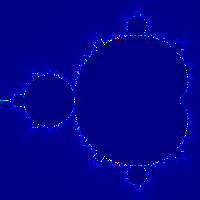

In [15]:
import cv2 # open computer vision library, for video and image processing
import matplotlib.pyplot as plt

# Make the image
image = _mandelbrot_cy(complex(-.5, 0), 2, view_side_pixels = 200)
# image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
# img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

In [16]:
from tqdm import tqdm
from multiprocessing import Pool
import os

frames = list()
def video_creator(view_size):
  # Create the image for the given parameters
  image = _mandelbrot_cy(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), view_side = view_size, n_max_iter=255, view_side_pixels = 100)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)
  return img
  # Store the frame
indata = tqdm(np.exp(np.linspace(np.log(1), np.log(.00001), 10)))
with Pool(processes=os.cpu_count()) as pool:
  frames = pool.map(video_creator, indata)

100%|██████████| 10/10 [00:00<00:00, 358.65it/s]


We achieved approx. 340 times acceleration.

Creating the high-res video

In [19]:
from tqdm import tqdm
from multiprocessing import Pool
import os

frames = list()
def video_creator(view_size):
  # Create the image for the given parameters
  image = _mandelbrot_cy(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), view_side = view_size, n_max_iter=255, view_side_pixels = 1000)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)
  return img
  # Store the frame
indata = tqdm(np.exp(np.linspace(np.log(1), np.log(.00001), 500)))
with Pool(processes=os.cpu_count()) as pool:
  frames = pool.map(video_creator, indata)

100%|██████████| 500/500 [00:00<00:00, 16599.27it/s]


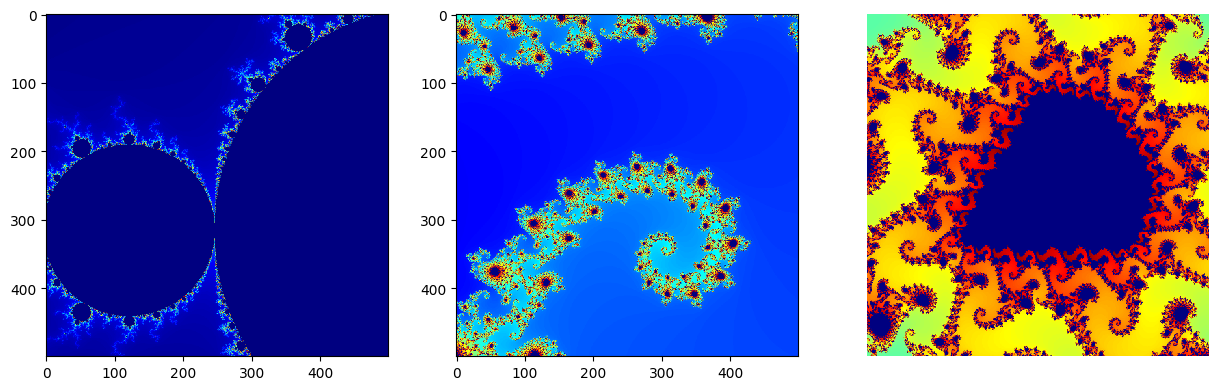

In [20]:
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frames[len(frames)//2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
# Choose video format
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Prepare the writer class
video = cv2.VideoWriter('fractal.mp4',fourcc, 20, (img.shape[0], img.shape[1]))

# Input the frames
for frame in frames:
  video.write(frame)

# Write to disk
video.release()

# Show the files in your working directory
!ls -l

total 24
-rw-r--r-- 1 root root   258 Feb 28 16:46 fractal.mp4
-rw-r--r-- 1 root root 10788 Feb 28 16:42 fractal.png
-rw-r--r-- 1 root root  2483 Feb 28 16:40 _mandelbrot.pyx
drwxr-xr-x 1 root root  4096 Feb  5 18:37 sample_data


Code for moving the data from colab to google drive.

In [0]:
# from google.colab import drive
# drive.mount('/gdrive')
# !cp fractal.mp4 /gdrive/'My Drive'/